# Feature Learning with K-means clustering, Nearest Neighbours, and Bag of Words.

In the previous Practical (PR1) we introduced the task of text/non-text classification. We have seen how training a Logistic Regression classifier using the images' raw pixels was not a good idea and we end up using a simple feature representation consisting in a histogram of the image's grey values.

In this practical we are going to improve the discrimination power of our classifier by learning a Bag of Words (BoW) representation. 

The roadmap is as follows:

* Import train/test data (raw image pixels). We use the same dataset as in PR1, raw_pixels_dataset_5980.pklz
* Extract small image patches from your training set
* Use K-Means to learn a vocabulary of Visual Words
* Represent the train images as BoW histograms and train the Logistic Regression classifier.
* Represent the test images as BoW histograms and evaluate results

### Usupervised Learning of Visual Words

Train_images shape (11960L, 1024L)
Test_images shape  (10396L, 1024L)


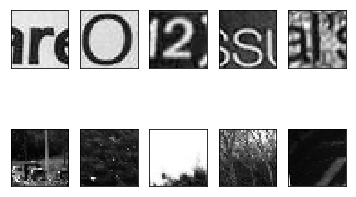

In [1]:
# Read the Dataset (Raw Pixels data). Use same dataset as in Project_PR1.
import pickle
import gzip
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

with gzip.open('../raw_pixels_dataset_5980.pklz','rb') as f:
  (train_labels,train_images,test_labels,test_images) = pickle.load(f)

print("Train_images shape " + str(train_images.shape))
print("Test_images shape  " + str(test_images.shape))

# Show a few samples of the positive and negative classes.
num_text = sum(train_labels==0)
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(np.reshape(train_images[np.random.randint(0,num_text),:],[32,32]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = fig.add_subplot(2, 5, i+5)
    ax.imshow(np.reshape(train_images[np.random.randint(num_text,train_labels.shape[0]),:],[32,32]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


Images shape (11960L, 32L, 32L)
Patches shape (191360L, 64L)


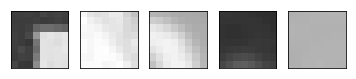

In [2]:
# Extract patches (of 8x8 pixels) from train images
import numpy as np

images = train_images.reshape((-1,32,32)).astype('float32')/255 # reshape images to 32x32
                                                                # and scale values to (0., 1.)
print("Images shape " + str(images.shape))

# Collect image patches with sliding window (8x8) in each train image sample
PATCH_SIZE=8;
STEP_SIZE =8;

patches = np.zeros((0,PATCH_SIZE,PATCH_SIZE))

for x in range(0, 32-PATCH_SIZE+1, STEP_SIZE):
    for y in range(0, 32-PATCH_SIZE+1, STEP_SIZE):
        patches = np.concatenate((patches, images[:,x:x+PATCH_SIZE,y:y+PATCH_SIZE]), axis=0)

patches = patches.reshape((patches.shape[0],-1))
print("Patches shape " + str(patches.shape))

# Visualize a few patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray, vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Now we contrast normalize our patches in order to gain illumination invariance. Each patch is normalized by pixel-wise subtracting its mean and dividing by its standard deviation.

D:\Users\byron\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in divide


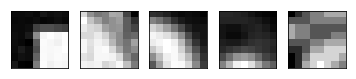

In [3]:
# PreProcessing (I) Contrast Normalization of Patches

mu = patches.mean(axis=1) # mean values
sigma = patches.std(axis=1) + np.ptp(patches, axis=1)/20.0 # standard deviation (plus a small value)

patches = (patches-mu.reshape([-1,1]))/(sigma.reshape([-1,1])) # subtract the mean and divide by std

# Set NaN values (if exist) to 0
w = np.isnan(patches);
patches[w] = 0;

# Visualize a few Constrast Normalized patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Next we perform ZCA whitening of the patches. 

We know how to use PCA to reduce the dimensionality of the data. ZCA whitening is a closely related preprocessing step. 

When we are working with images the raw input is redundant, because the values of adjacent pixels in an image are highly correlated. The goal of whitening is to decorrelate pixel values with each other and make them all have the same variance.

ZCA whitening is implemented as follows:

* First, subtract the mean value of each pixel in image patches to make our data zero-mean.
* Then, as in PCA, compute the eigenvectors of the patches' covariance matrix $\Sigma$.
* The ZCA whitened data is then : 

       $x_{ZCAwhite} = U * diag(1./\sqrt{diag(S) + \epsilon)} * U' * x$

where $U$ contains the eigenvectors of $\Sigma$, $S$ contains the corresponding eigenvalues, $\epsilon$ is a trivial small value and $x$ is the input data (image patches).

More info: http://ufldl.stanford.edu/wiki/index.php/Whitening

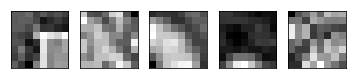

In [4]:
# PreProcessing (II) ZCA Whitening of normalized patches

eig_values, eig_vec = np.linalg.eig(np.cov(patches.T))
epsilon = 0.01
pca = eig_vec.dot(np.diag((eig_values+epsilon)**-0.5).dot(eig_vec.T))


M =  patches.mean(axis=0)
patches = patches -  M # subtract average value
patches = np.dot(patches, pca) # perform pca whitening


# Visualize a few PreProcessed patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Once we have our preprocessed training patches we can perform Unsupervised Learning analysis (K-means clustering) to learn the K visual Words vocabulary.  Then we'll use these vocabulary to represent an image as an histogram of the occurrences of its Words.

In [5]:
# K-means clustering to learn K visual_words from data
from sklearn.cluster import KMeans

NUM_VISUAL_WORDS = 64

km = KMeans(n_clusters=NUM_VISUAL_WORDS, max_iter=50, n_init=1, verbose=False)
km.fit(patches)

visual_words = km.cluster_centers_
print("Visual_words shape " + str(visual_words.shape))

Visual_words shape (64L, 64L)


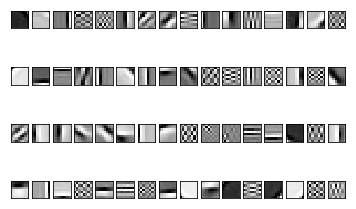

In [6]:
# Visualize the learned vocabulary of Visual Words

from matplotlib import pyplot as plt
import matplotlib.cm as cm
#%pylab inline

fig = plt.figure()
num_col = int(np.ceil(float(NUM_VISUAL_WORDS)/4))
for i in xrange(NUM_VISUAL_WORDS):
    ax = fig.add_subplot(4, num_col, i+1)
    visual_word_ = visual_words[i,:]
    visual_word_ = visual_word_.reshape(PATCH_SIZE,PATCH_SIZE);
    ax.imshow(visual_word_, interpolation='none', cmap = cm.Greys_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Extract Image features using Bag of Words

A Bag of Visual Words is a histogram of occurrence counts of the vocabulary words.

In our case we have 64 Words in the vocabulary, hence the histogram will have 64 bins. 

To represent an image we'll extract image patches, preprocess them, and find its Nearest Neighbor Word in the vocabulary. Finally, each Nearest Neighbor found increments in 1 unit the value of its respective bin in the BoW histogram. 

In [7]:
# Learn a KNN classifier, Each visual Word represents one class
# In this case KNN is used simply as a way to search of the nearest neighbor Visual Word 
# in our vocabulary.
from sklearn.neighbors import KNeighborsClassifier

neig = KNeighborsClassifier(n_neighbors=1)
neig.fit(visual_words,range(0,NUM_VISUAL_WORDS));

In [8]:
# Extract features from train images
train_features = np.zeros((images.shape[0],visual_words.shape[0]));

for i in range(0,images.shape[0]): # for each image

  # Do sliding window (8x8) in each image to extract patches
  #    then normalize, whiten and build the Bag of Words histogram
  for x in range(0,32-PATCH_SIZE+1,STEP_SIZE):
    for y in range(0,32-PATCH_SIZE+1,STEP_SIZE):
        patch = images[i,x:x+PATCH_SIZE,y:y+PATCH_SIZE]
        patch = patch.reshape((1,-1))
        # PreProcessing (I): Normalize
        mu = patch.mean(axis=1) # mean values
        sigma = patch.std(axis=1) + max(np.ptp(patch, axis=1)/20.0, 0.0001) # standard deviation 
                                                               # (plus a small value)
        patch = (patch-(mu[np.newaxis,:]).T)/(sigma[np.newaxis,:]).T
        # Set NaN values to 0
        w = np.isnan(patch);
        patch[w] = 0;
        
        # PreProcessing (II): ZCA whitening
        patch = patch - M # subtract average value
        patch = np.dot(patch, pca) # perform pca whitening
        
        # BoW
        nn = neig.predict(patch)
        train_features[i,nn] = train_features[i,nn] + 1;
        
  train_features[i,:] = train_features[i,:]/max(train_features[i,:]) # Histogram normalization

In [9]:
# If you want to save your training features
import pickle
import gzip

with gzip.open('./BoW_train_features.pklz','wb') as f:
    pickle.dump((train_labels,train_features),f,pickle.HIGHEST_PROTOCOL)

In [10]:
# Extract features from test images
images = test_images.reshape((-1,32,32)).astype('float32')/255
test_features = np.zeros((images.shape[0],visual_words.shape[0]));

for i in range(0,images.shape[0]): #for each image
    
  # Do sliding window (8x8) in each image to extract patches
  #    then normalize, whiten and build the Bag of Words histogram
  for x in range(0,32-PATCH_SIZE+1,STEP_SIZE):
    for y in range(0,32-PATCH_SIZE+1,STEP_SIZE):
        patch = images[i,x:x+PATCH_SIZE,y:y+PATCH_SIZE]
        patch = patch.reshape((1,-1))
        # PreProcessing (I): Normalize
        mu = patch.mean(axis=1) # mean values
        sigma = patch.std(axis=1) + max(np.ptp(patch, axis=1)/20.0, 0.0001) # standard deviation 
                                                               # (plus a small value)
        patch = (patch-(mu[np.newaxis,:]).T)/(sigma[np.newaxis,:]).T
        # Set NaN values to 0
        w = np.isnan(patch);
        patch[w] = 0;
        
        # PreProcessing (II): ZCA whitening
        patch = patch - M # subtract average value
        patch = np.dot(patch, pca) # perform pca whitening

        # BoW
        nn = neig.predict(patch)
        test_features[i,nn] = test_features[i,nn] + 1;
        
  test_features[i,:] = test_features[i,:]/max(test_features[i,:])  # Histogram normalization

In [11]:
# If you want to save your test features
import pickle
import gzip

with gzip.open('./BoW_test_features.pklz','wb') as f:
    pickle.dump((test_labels,test_features),f,pickle.HIGHEST_PROTOCOL)

## <font color='red'>Exercise 1: Logistic Regression classification with BoW features.</font>

Train a Logistic Regression classifier with the learned BoW features. Use your Logistic Regression and Gradient Descent code from Project_PR1. Explain how you have set the parameters of the Gradient Descent algorithm.

Compare the Test Accuracy, Precision, and Recall with the obtained in Practical_PR1 with the histograms of grey values. Show the confusion matrices and Precision/Recall curves.

Analyze the effect of PreProcessing the image patches. Show test Accuracy w./w.o. Contrast Normalization / PCA whitening. Visualize the vocabularies of learned Visual Words. Comment the results.


<table>
    <tr>
        <td> Method </td>
        <td> Test Accuracy </td>
        <td> Precision </td>
        <td> Recall </td>
    </tr>
    <tr>
        <td colspan=2></td>
    </tr>
    
    <tr>
        <td> Grey Level Histograms </td>
        <td> 73.97 % </td>
        <td> - </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> BoW (No preprocessing) </td>
        <td> - </td>
        <td> - </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> BoW  </td>
        <td> - </td>
        <td> - </td>
        <td> - </td>
    </tr>
</table>

## <font color='red'>Exercise 2: Effect of vocabulary size in BoW.</font>

Train and test your classifier using different sizes for the vocabulary (NUM_VISUAL_WORDS). Make a plot of Test Accuracy as a function of the vocabulary size.

Train and test your classifier by modifying the number of patches extracted from each image. This is, modify the STEP_SIZE parameter to make patch extraction more dense. How it does affect on the classifier's Accuracy? Are the vocabulary size and patch density parameters related?

<table>
    <tr>
        <td> Num. Visual Words </td>
        <td> Step Size </td>
        <td> Test Accuracy </td>
    </tr>
    <tr>
        <td colspan=2></td>
    </tr>
    
    <tr>
        <td> 32 </td>
        <td> 8 </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> 64 </td>
        <td> 8 </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> 64 </td>
        <td> 4 </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> 128 </td>
        <td> 8 </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> 128 </td>
        <td> 4 </td>
        <td> - </td>
    </tr>
</table>

## <font color='red'>Exercise 3: K-NN Classifier.</font>

Train a K-NN classifier for text/non-text classification using the learned BoW representations.

Compare the Accuracy using different values of K for the K-NN classifier with the Accuracy of the Logistic Regression classifier. Comment the advantages/disadvantages of each classifier.

<table>
    <tr>
        <td> Method </td>
        <td> Test Accuracy </td>
        <td> Precision </td>
        <td> Recall </td>
    </tr>
    <tr>
        <td colspan=2></td>
    </tr>
    
    <tr>
        <td> K-NN (K=3) </td>
        <td> - </td>
        <td> - </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> K-NN (K=7) </td>
        <td> - </td>
        <td> - </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> Logistic Regression Classifier </td>
        <td> - </td>
        <td> - </td>
        <td> - </td>
    </tr>
</table>

## <font color='red'>Exercise 4: Open Exercise (optional)</font>

Propose and implement an improvement, or an extra evaluation analysis, for our Text vs. Non-text classifier in its current status.

Some ideas (not a closed list):

* Compare the performance of BoW using hard assignment (each patch counts 1 only to the bin of its nearest visual Word) and soft assignment (each patch counts "d" to the K bins of its K-NNs, where "d" is proportional to the NN distance).

* Improve the BoW representation by using spatial information (Spatial Pyramids).

* Evaluate the Test Accuracy as a function of of patch size.

* Evaluate the Test Accuracy as a function of the number of training examples ($m$).

* Use cross-validation to tune the meta-parameters (vocabulary size, patch_size) of BoW. 

* Compare ZCA and PCA whitening.

* Implement the Stochastic Gradient Descent algorithm. Show how it improves the training time performance.
